# Imports

In [43]:
import pandas as pd
import re
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score

# Macros

In [5]:
DATA_FOLDER = '../../data/'
FIG_FOLDER = '../../figures/'

plt.style.use('seaborn-whitegrid')

# Utile Function

## Sklean Pipline Pandas support

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

## Save Fig

In [11]:
def save_fig(sec_name, fig_name, tight_layout=True):
    path = os.path.join(FIG_FOLDER , sec_name + '_'  + fig_name + ".png")
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

# Feature Engineering

## Employment_title_ident

### Section Data Import

In [3]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget.pkl')

# https://www.kaggle.com/ash316/forbes-top-2000-companies
df_company = pd.read_csv(DATA_FOLDER + 'forbes2013.csv') # company names to get label for known companys

### match known companys

In [4]:
df['emp_ident'] = df['emp_title']

In [5]:
KNOWN_COMPANY_MARKER = 'known_company'

def title_id_known_company(emp_title_entry):
    try:
        founds = df_company.Company.str.contains(emp_title_entry).value_counts()
    except:
        return emp_title_entry
    
    if len(founds)>1:
         return KNOWN_COMPANY_MARKER
    else:
        return emp_title_entry

In [6]:
df['emp_ident'] = df['emp_ident'].apply(lambda emp_title: title_id_known_company(emp_title))
#df['emp_ident'].value_counts()

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


### match groups like army, public, self employment ...

In [7]:
def title_to_ident(emp_title_entry):
    if emp_title_entry == KNOWN_COMPANY_MARKER:
        return emp_title_entry
    elif (re.search('Army|Military',emp_title_entry ,re.I) is None) == False :
        return 'army'
    elif (re.search('self',emp_title_entry ,re.I) is None) == False :
        return 'self_emp'
    elif (re.search('city|state|public|district|school|schools|Government|Sheriff|county|civil|police|National Guard',emp_title_entry ,re.I) is None) == False :
        return 'puplic'
    elif (re.search('bank',emp_title_entry ,re.I) is None) == False :
        return 'bank'
    else:
        return 'unknown' 

In [10]:
df['emp_ident'] = df['emp_ident'].apply(lambda emp_title: title_to_ident(emp_title))
df['emp_ident'].value_counts()

unknown          31255
puplic            3696
known_company     2464
bank               696
army               476
self_emp           231
Name: emp_ident, dtype: int64

### Export data with feature added

In [11]:
df.to_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

## feature importance test

### Section data import

In [6]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

### pick the possible features 

In [7]:

x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

y_col = ['target']

df_x = df[x_col]
df_y = df[y_col]

### Encoding the dummys with pandas

In [8]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38818 entries, 1 to 42474
Data columns (total 80 columns):
annual_inc                             38818 non-null float64
dti                                    38818 non-null float64
emp_length                             38818 non-null float64
loan_amnt                              38818 non-null float64
open_acc                               38818 non-null float64
pub_rec                                38818 non-null float64
pub_rec_bankruptcies                   38818 non-null int64
addr_state_AL                          38818 non-null uint8
addr_state_AR                          38818 non-null uint8
addr_state_AZ                          38818 non-null uint8
addr_state_CA                          38818 non-null uint8
addr_state_CO                          38818 non-null uint8
addr_state_CT                          38818 non-null uint8
addr_state_DC                          38818 non-null uint8
addr_state_DE                          

### create preprocessing pipeline

In [12]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('int64'),
        )),
        ("dummy_features", make_pipeline(
            TypeSelector('uint8'),
        )),
        #("categorical_features", make_pipeline(
        #    TypeSelector("category"),
        #    OneHotEncoder()
        #)),
    ]))

In [13]:
# checks onf the preprocessing pipline
preprocess_pipeline.fit(df_x_encoded)
X_transformed = preprocess_pipeline.transform(df_x_encoded)    
print(X_transformed.shape)
print(df_x_encoded.shape)
df_y.shape
#df.info()

(38818, 80)
(38818, 80)


(38818, 1)

### calculate decision tree importance

In [14]:
clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=6,max_leaf_nodes=2)
clf.fit(X_transformed, df_y)
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=df_x_encoded.columns, columns=["Importance"])
importance = importance.sort_values(['Importance'], ascending=True)
print(precision_score(df_y.values, clf.predict(X_transformed)))
accuracy_score(df_y, clf.predict(X_transformed))

1.0


1.0

Saving figure dectree_feat_importance


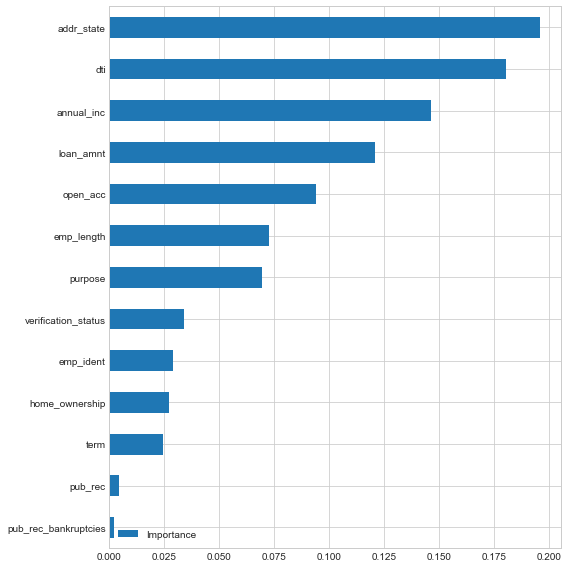

In [15]:
# create plot with joined importance of dummys
importance_join = pd.DataFrame(index = df_x.columns)
for i1 in df_x.select_dtypes('object').columns:
    #print(i1)
    t_sum = 0
    for i2 in importance.index:
        if i1 in i2:
            #print ('--' + i2)
            t_sum += importance.loc[i2,'Importance']
    
    importance_join.loc[i1,'Importance'] = t_sum
            
for i in df_x.select_dtypes(np.number).columns:
    importance_join.loc[i,'Importance'] = importance.loc[i,'Importance']
    
importance_join = importance_join.sort_values(['Importance'], ascending=True)
importance_join.plot(kind='barh', figsize=(8,8))

save_fig('feat_eng', 'dectree_feat_importance', tight_layout=True)

## feature correlation

### Section data import

In [16]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

### correlation head map

In [17]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

y_col = ['target']

In [18]:
# calculate the correlation matrix
df_xy_encoded = pd.get_dummies(df[y_col + x_col], drop_first=True)
corr = df_xy_encoded.corr()

corr = corr.target
importance.name = 'correlation'



In [24]:
corr_join = pd.Series(index = df[y_col + x_col].columns)
for i1 in df[y_col + x_col].select_dtypes('object').columns:
    #print(i1)
    t_sum = 0
    for i2 in corr.index:
        if i1 in i2:
            #print ('--' + i2)
            t_sum += corr[i2]
    
    corr_join.loc[i1] = t_sum
            
for i in df[y_col + x_col].select_dtypes(np.number).columns:
    corr_join[i] = corr[i]
    
corr_join.apply(lambda x: abs(x)).sort_values(ascending = False).drop('target')

term                    0.156560
loan_amnt               0.055218
pub_rec                 0.053128
pub_rec_bankruptcies    0.050241
dti                     0.045651
purpose                 0.041740
annual_inc              0.035885
verification_status     0.033529
home_ownership          0.031948
addr_state              0.019093
emp_length              0.018520
open_acc                0.002009
emp_ident               0.000184
dtype: float64

Saving figure feat_target_corr


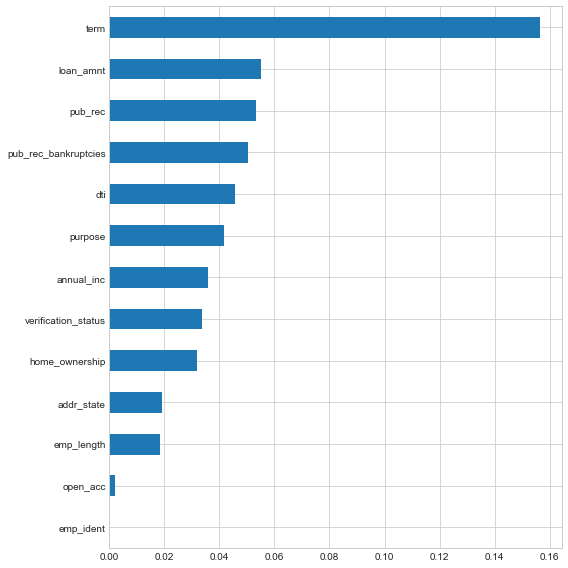

In [26]:
corr_join.apply(lambda x: abs(x)).sort_values(ascending = True).drop('target').plot(kind='barh', figsize=(8,8))
save_fig('feat_eng', 'feat_target_corr', tight_layout=True)

## Combine correlation and feature importance (you need both in memory)

In [44]:
imcor = importance_join.join(pd.DataFrame(corr_join.apply(lambda x: abs(x)), columns=['correlation']))
imcor['c'] = MinMaxScaler().fit_transform(imcor.correlation.values.reshape(-1, 1))
imcor['i'] = MinMaxScaler().fit_transform(imcor.Importance.values.reshape(-1, 1))
imcor = imcor.eval('sum = c + i')
imcor.sort_values(by=['sum'], ascending = False)

,Importance,correlation,c,i,sum
dti,0.180349,0.045651,0.290753,0.920449,1.211202
addr_state,0.195742,0.019093,0.120923,1.000000,1.120923
term,0.024511,0.156560,1.000000,0.115079,1.115079
annual_inc,0.146095,0.035885,0.228302,0.743426,0.971728
loan_amnt,0.120713,0.055218,0.351934,0.612252,0.964186
purpose,0.069347,0.041740,0.265748,0.346792,0.612539
open_acc,0.094195,0.002009,0.011673,0.475206,0.486878
emp_length,0.072460,0.018520,0.117261,0.362878,0.480139
verification_status,0.034033,0.033529,0.213237,0.164286,0.377522
pub_rec,0.004138,0.053128,0.338572,0.009791,0.348363


--- > this can be used to choose the features